In [1]:
import numpy as np
from partition_decode.models import ReluNetClassifier
from partition_decode.dataset import generate_gaussian_parity, recursive_gaussian_parity, generate_spirals
import torch

In [2]:
X, y = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=None, cov_scale=1.0
)

# X, y = recursive_gaussian_parity(
#     n_samples=1024, recurse_level=2, random_state=None, cov_scale=0.3
# )

# X, y = generate_spirals(
#     n_samples=1024, random_state=None, noise=0.7
# )

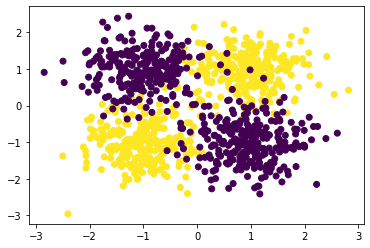

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [60]:
net = ReluNetClassifier(
    verbose=1, n_epochs=200, hidden_layer_dims=[1000],
    learning_rate=0.01, early_stop_thresh=0)#, loss=torch.nn.BCEWithLogitsLoss)
net = net.fit(X, y)

Results for epoch 1, CrossEntropyLoss=0.70, 01_error=0.49
Results for epoch 6, CrossEntropyLoss=0.55, 01_error=0.17
Results for epoch 11, CrossEntropyLoss=0.31, 01_error=0.09
Results for epoch 16, CrossEntropyLoss=0.18, 01_error=0.09
Results for epoch 21, CrossEntropyLoss=0.12, 01_error=0.02
Results for epoch 26, CrossEntropyLoss=0.18, 01_error=0.07
Results for epoch 31, CrossEntropyLoss=0.22, 01_error=0.06
Results for epoch 36, CrossEntropyLoss=0.20, 01_error=0.09
Results for epoch 41, CrossEntropyLoss=0.15, 01_error=0.08
Results for epoch 46, CrossEntropyLoss=0.12, 01_error=0.05
Results for epoch 51, CrossEntropyLoss=0.12, 01_error=0.05
Results for epoch 56, CrossEntropyLoss=0.17, 01_error=0.08
Results for epoch 61, CrossEntropyLoss=0.13, 01_error=0.06
Results for epoch 66, CrossEntropyLoss=0.16, 01_error=0.08
Results for epoch 71, CrossEntropyLoss=0.23, 01_error=0.09
Results for epoch 76, CrossEntropyLoss=0.17, 01_error=0.09
Results for epoch 81, CrossEntropyLoss=0.15, 01_error=0.07

In [11]:
net = net.fit(X, y)

Results for epoch 1, bce_loss=0.64, 01_error=0.32
Results for epoch 6, bce_loss=0.61, 01_error=0.32


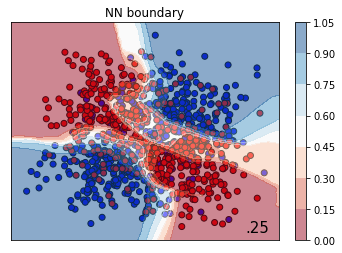

In [144]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, 1, 1)

# Plot the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors="k")
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

score = net.score(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = net.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('NN boundary')
ax.text(
    xx.max() - 0.3,
    yy.min() + 0.3,
    ("%.2f" % score).lstrip("0"),
    size=15,
    horizontalalignment="right",
)
plt.colorbar()
plt.show()

In [145]:
irm = net.get_internal_representation(X, penultimate=False)

## Parameter impute

In [142]:
X_train, y_train = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=None, cov_scale=1.0
)

# X, y = recursive_gaussian_parity(
#     n_samples=1024, recurse_level=2, random_state=None, cov_scale=0.3
# )

# X, y = generate_spirals(
#     n_samples=1024, random_state=None, noise=0.7
# )

In [143]:
model = ReluNetClassifier(
    verbose=1, n_epochs=10, hidden_layer_dims=[10],
    learning_rate=0.01, early_stop_thresh=0)#, loss=torch.nn.BCEWithLogitsLoss)

In [144]:
model = model.fit(X_train, y_train)
with torch.no_grad():
    print(np.mean(y_train == model.predict(X_train)))

# model.n_epochs = 0
# model._train_model(X_train, y_train)
# print(np.mean(y_train == model.predict(X_train)))

Results for epoch 1, CrossEntropyLoss=0.73, 01_error=0.50
Results for epoch 6, CrossEntropyLoss=0.49, 01_error=0.23
0.7373046875


In [145]:
new_model = ReluNetClassifier(verbose=1, n_epochs=0, hidden_layer_dims=[20],
    learning_rate=0.01, early_stop_thresh=0
)
new_model._build_model(X_train.shape[-1], len(np.unique(y_train)))
with torch.no_grad():
    for prior_layer, new_layer in zip(model.model_, new_model.model_,):
        if isinstance(new_layer, torch.nn.ReLU):
            continue
        width, depth = prior_layer.weight.shape
        new_layer.weight[:width, :depth] = prior_layer.weight
        new_layer.bias[:width] = prior_layer.bias

new_model._train_model(X_train, y_train)

In [146]:
print(np.mean(y_train == new_model.predict(X_train)))

0.73046875


In [147]:
new_model.model_[0].weight

Parameter containing:
tensor([[-0.6229,  0.6128],
        [-0.2899,  0.2469],
        [ 0.6234, -0.0520],
        [-0.6382,  0.6064],
        [ 0.6041,  0.8540],
        [-0.2757,  0.3778],
        [ 0.0388,  0.1128],
        [-0.9102, -0.5263],
        [-0.6184,  0.3038],
        [-0.1628, -0.6668],
        [ 0.0841, -0.1184],
        [ 0.2108, -0.3145],
        [ 0.0176,  0.5059],
        [ 0.2708,  0.3724],
        [ 0.3626, -0.2471],
        [-0.0148,  0.2273],
        [ 0.3343, -0.2632],
        [-0.0415,  0.4311],
        [ 0.4919, -0.2792],
        [-0.0914,  0.4419]], requires_grad=True)

In [148]:
model.model_[0].weight

Parameter containing:
tensor([[-0.6229,  0.6128],
        [-0.2899,  0.2469],
        [ 0.6234, -0.0520],
        [-0.6382,  0.6064],
        [ 0.6041,  0.8540],
        [-0.2757,  0.3778],
        [ 0.0388,  0.1128],
        [-0.9102, -0.5263],
        [-0.6184,  0.3038],
        [-0.1628, -0.6668]], requires_grad=True)

In [129]:
model.model_

Sequential(
  (linear0): Linear(in_features=2, out_features=10, bias=True)
  (relu0): ReLU()
  (linear1): Linear(in_features=10, out_features=2, bias=True)
)